# VQVAE for Image Generation - FashionMNIST Dataset
**Author:** Jeanne Malécot 

## Getting Started

In [1]:
#useful imports
import os
import copy

import torch
import torchvision
import torchvision.transforms as transforms
import torchinfo
import random

import matplotlib.pyplot as plt

from scripts.train import train_model
from scripts.reconstruct import reconstruct, show_recon
from models.vqvae import VQVAE

##### Load FashionMNIST dataset

In [2]:
#load FashionMNIST
train_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
test_set = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=transforms.ToTensor()
)

print(f"len train set: {len(train_set)}\nlen test set: {len(test_set)}")
print(f"image shape: {train_set[0][0][0].shape}")

len train set: 60000
len test set: 10000
image shape: torch.Size([28, 28])


## Training VQVAE for reconstruction

In [3]:
#device
device = "cuda" if torch.cuda.is_available() else "cpu"
print('device:', device)

device: cuda


In [ ]:
#config
basic_config = {
    'n_epochs': 30, 
    'lr': 0.001, 
    'model': {
        'batch_size': 100, 
        'n_channels': 1, 
        'channels': [64, 128],
        'latent_dim': 20,
        'n_embedding': 20,
        }
    } 

In [19]:
model_dicts = []
lr_list = [0.03, 0.01, 0.001]
batch_size_list = [50, 100, 200]
channels = [[16, 32], [32, 64], [64, 128], [128, 256]]
latent_dim = [k for k in range(10, 101, 10)]
n_embedding_list = [k for k in range(10,501,10)]

grid = [(lr, batch_size, channel, latent, n_embedding) for lr in lr_list for batch_size in batch_size_list for channel in channels for latent in latent_dim for n_embedding in n_embedding_list]

18000


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (18000, 5) + inhomogeneous part.

Model architecture:

In [5]:
vqvae = vqvae = VQVAE(basic_config['model']).to(device)
print(torchinfo.summary(vqvae, (1, 1, 28,28), device = str(device)))

Layer (type:depth-idx)                        Output Shape              Param #
VQVAE                                         [1, 1, 28, 28]            --
├─EncoderBlock: 1-1                           [1, 20, 7, 7]             --
│    └─ModuleList: 2-1                        --                        --
│    │    └─Sequential: 3-1                   [1, 64, 14, 14]           640
│    │    └─Sequential: 3-2                   [1, 128, 7, 7]            73,856
│    │    └─Sequential: 3-3                   [1, 20, 7, 7]             2,580
├─VectorQuantizer: 1-2                        [1, 20, 7, 7]             400
├─DecoderBlock: 1-3                           [1, 1, 28, 28]            --
│    └─ModuleList: 2-2                        --                        --
│    │    └─Sequential: 3-4                   [1, 128, 7, 7]            2,688
│    │    └─Sequential: 3-5                   [1, 64, 14, 14]           32,832
│    │    └─Sequential: 3-6                   [1, 1, 28, 28]            257
├─C

#### Fine tuning of the VQ-VAE

- Number of Embeddings:

In [6]:
#reconstruct
model_dicts = []
n_embedding_list = [k for k in range(10,501,50)]


for i, n_embeddings in enumerate(n_embedding_list):
    config = copy.deepcopy(basic_config)
    config['model']['n_embedding'] = n_embeddings
    print(f"==========\nTRAINING  {i+1}/{len(n_embedding_list)}:") 
    model_dicts.append(train_model("vqvae", train_set, config, device))
    print(f"Training Loss: {model_dicts[i]['train_loss']:.4f} | Validation Loss: {model_dicts[i]['val_loss']:.4f}")

TRAINING  1/1:


Output()

Training Loss: 0.0301 | Validation Loss: 0.0301


In [12]:
#select model with lower accuracy
sorted_dicts = sorted(model_dicts, key=lambda x:x['val_loss'])

best_config = sorted_dicts[0]['config']
best_model = sorted_dicts[0]['model']

print(f"Config updated with n_embeddings = {best_config['model']['n_embedding']}")


Config updated with n_embeddings = 784


Reconstructing images:   0%|          | 0/10000 [00:00<?, ?it/s]

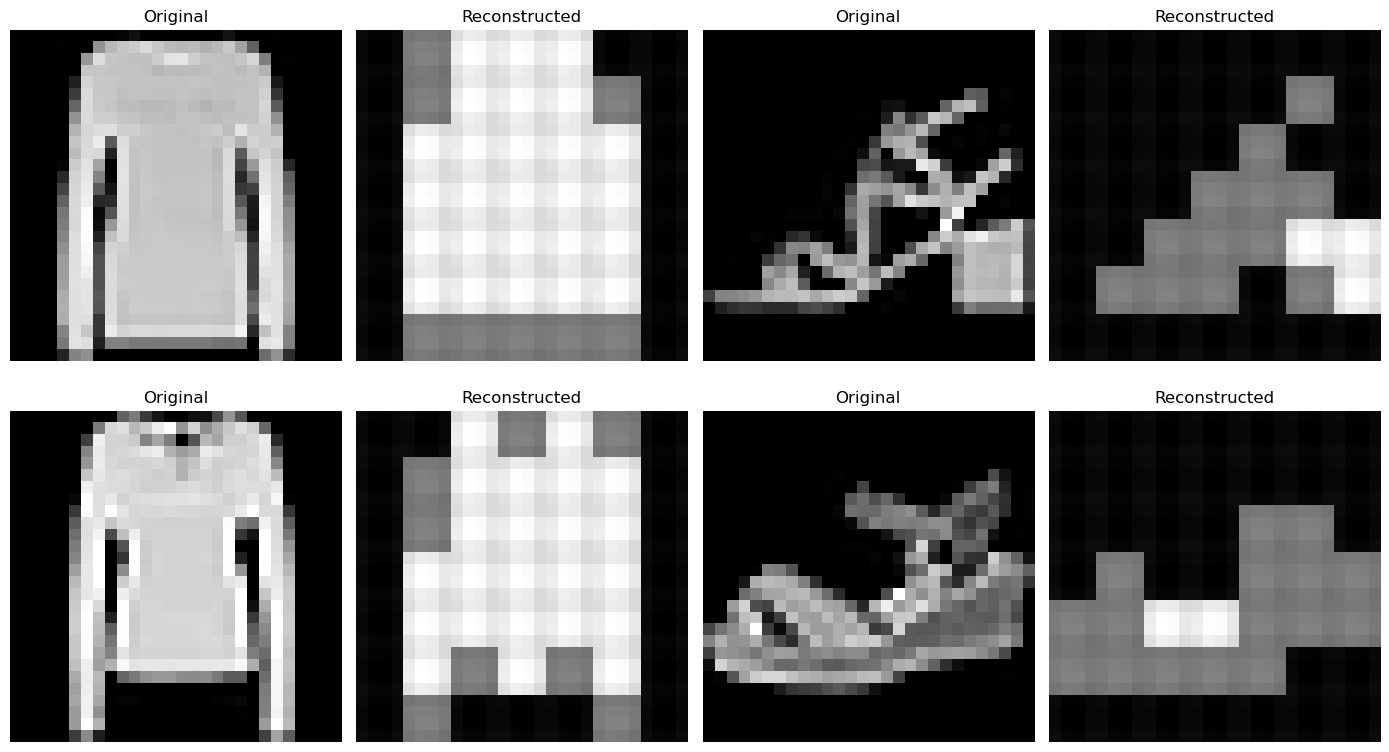

In [13]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress  ",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",²
    9: "Ankle Boot",
}

image_dicts, label_dist = reconstruct(best_model, test_set, device)
show_recon(image_dicts)

torch.Size([28, 28])


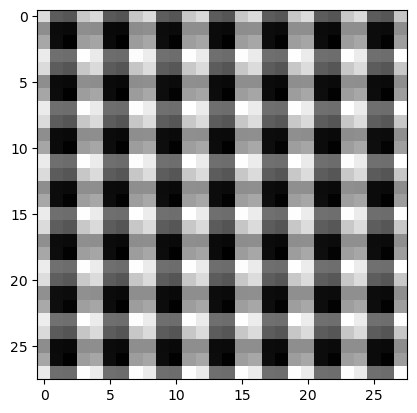

In [9]:
#generate sneakers
sneakers_dist = label_dist[2]
# print(sneakers_dist)

generated_image = best_model.generate(sneakers_dist, (28,28))
print(generated_image.shape)
plt.imshow(generated_image.detach().cpu().numpy(), cmap = 'gray')